# ML Model

## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sys
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot
np.set_printoptions(edgeitems=3, infstr='inf',
linewidth=75, nanstr='nan', precision=3,
suppress=False, threshold=1000, formatter=None)

##Importing the dataset

In [ ]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse,header=0)
dataset.index.name = 'date'
print(dataset)

                        No  pm2.5  DEWP  TEMP    PRES cbwd     Iws  Is  Ir
date                                                                      
2010-01-01 00:00:00      1    NaN   -21 -11.0  1021.0   NW    1.79   0   0
2010-01-01 01:00:00      2    NaN   -21 -12.0  1020.0   NW    4.92   0   0
2010-01-01 02:00:00      3    NaN   -21 -11.0  1019.0   NW    6.71   0   0
2010-01-01 03:00:00      4    NaN   -21 -14.0  1019.0   NW    9.84   0   0
2010-01-01 04:00:00      5    NaN   -20 -12.0  1018.0   NW   12.97   0   0
...                    ...    ...   ...   ...     ...  ...     ...  ..  ..
2014-12-31 19:00:00  43820    8.0   -23  -2.0  1034.0   NW  231.97   0   0
2014-12-31 20:00:00  43821   10.0   -22  -3.0  1034.0   NW  237.78   0   0
2014-12-31 21:00:00  43822   10.0   -22  -3.0  1034.0   NW  242.70   0   0
2014-12-31 22:00:00  43823    8.0   -22  -4.0  1034.0   NW  246.72   0   0
2014-12-31 23:00:00  43824   12.0   -21  -3.0  1034.0   NW  249.85   0   0

[43824 rows x 9 columns]

We can see that from below. There are missing values only ​​in the dependent variable.

In [ ]:
num_vars = dataset.columns[dataset.dtypes != 'object']
cat_vars = dataset.columns[dataset.dtypes == 'object']
dataset[num_vars].isnull().sum()

No          0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
dtype: int64

###Plot with 7 subplots showing the 5 years of data for each variable.

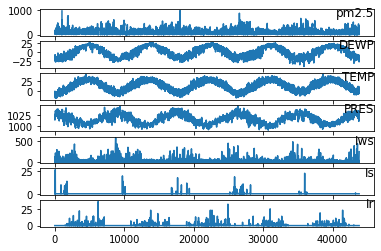

In [ ]:
values = dataset.values
groups = [1, 2, 3, 4, 6, 7, 8]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

##Encoding categorical data (Wind direction)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [5])], remainder='passthrough')
dataset_values =(ct.fit_transform(dataset))

##Taking care of missing data

**In this part use Random Forest Regression model for missing value**

###Data Preprocessing

Data is divided into 2 according to whether pm2.5 values ​​are present or not.
Then apply encoder created before on Encoding categorical data part.

In [ ]:
null_data = dataset[dataset.isnull().any(axis=1)]
full_data = dataset.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#apply encoder created before on Encoding categorical data part.
full_data_values = (ct.fit_transform(full_data))
null_data_values = (ct.fit_transform(null_data))

Separate data as dependent and independent variables. While the 5th column in the data is the dependent variable, the other data is the independent variable.

In [ ]:
x_train =  full_data_values[:,[0,1,2,3,4,6,7,8,9,10,11]]
y_train =  full_data_values[:,5]
y_train = y_train.reshape(len(y_train),1)
x_test =  null_data_values[:,[0,1,2,3,4,6,7,8,9,10,11]]




###Feature Scaling

Feature scalling is not required for Random Forest regression analysis, but I added it for convenience when switching to another model.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
x_train_prep = sc_X.fit_transform(x_train)
y_train_prep = sc_y.fit_transform(y_train)
x_test_prep = sc_X.transform(x_test)

###Applying PCA

Since we filled in the missing data in this section, feature reduction was used to make the model work fast.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
x_train_prep = pca.fit_transform(x_train_prep)
x_test_prep = pca.transform(x_test_prep)

###Training the Random Forest Regression model on the full data set


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train_prep, y_train_prep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

###Predict Missing Values

In this section, first an estimate is made for the null values.
We keep null values ​​as they will be used in model evaluation. The dependent variables, predictive values ​​and null values ​​are collected in an array to form the data of the main model.

In [ ]:
#first an estimate is made for the null values.
predict_y = sc_y.inverse_transform(regressor.predict(x_test_prep))
predict_y = predict_y.reshape(len(predict_y),1)

#We keep null values ​​as they will be used in model evaluation.
old_y_values=null_data_values[:,5]
old_y_values = old_y_values.reshape(len(old_y_values),1)

#The dependent variables, predictive values ​​and null values ​​are collected in an array to form the data of the main model.
new_values=np.append(x_test,predict_y,axis=1)
new_values=np.append(new_values,old_y_values,axis=1)





Since non-null values ​​are not predictive values, we fill that part with their own values. Then, combining null data and full data arrays, sorted by number.

---
The new_data_set value has become the data collection that I will use in our original model. The taking care of missing data party ends here.


In [ ]:
#Since non-null values ​​are not predictive values, we fill that part with their own values.
y_values_full_data=full_data_values[:,5]
y_values_full_data = y_values_full_data.reshape(len(y_values_full_data),1)

#The dependent variables, dependent values ​​are collected in an array to form the data of the main model.
new_values_full_data=np.append(x_train,y_values_full_data,axis=1)
full_data_values=np.append(new_values_full_data,y_values_full_data,axis=1)
#Combining null data and full data arrays, sorted by number.
#The new_data_set value has become the data collection that I will use in our original model.
new_data_set=np.append(full_data_values,new_values,axis=0)
new_data_set = np.asarray(sorted(new_data_set, key=lambda x:x[4]))


##Convert Time Series to Supervised Learning

###Function for convert Time Series to Supervised Learning

In this function, a desired historical data is added to our dataset. 
In this model, only the historical values ​​of pm2.5 are added to the data.

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False, time=1):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i*time))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i*time))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

###Use the series_to_supervised function to finalize dataset.

Using the series_to_supervised function, pm2.5 values ​​of the past hour and the previous day are calculated. These values ​​are added to new_data_set.

In [ ]:
reframed_last_hour = series_to_supervised(new_data_set[:,[11]], 1, 1,False,1)
reframed_last_day = series_to_supervised(new_data_set[:,[11]], 1, 1,False,24)
new =[reframed_last_hour.iloc[:,0],reframed_last_day.iloc[:,0]]
result = pd.concat(new,axis=1, join="inner")

#new_data_set has been finalized.
new_data_set=np.append(new_data_set,result,axis=1)


##Splitting the dataset into the Training set and Test set

The pm2.5 value of the first 24 values ​​was removed from the dataset because they were empty and they did not have any previous values.

In [ ]:
new_data_set=new_data_set[24:]

New dependent and independent variables were determined.

In [ ]:
X=np.delete(new_data_set, [4,11,12], 1)
y=new_data_set[:,[4,11,12]]

These values ​​were divided into two as train and test.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

##Training the Random Forest Regression model on the Train dataset

We have 2 different y values. The first y values ​​are data with null values. The second y values ​​are the values ​​in which the empty values ​​are replaced with the estimated values ​​after the calculations in the first part.

---
In order for the model to work better, we will use the second y values ​​in the model.


In [ ]:
y_real=y_train[:,[2]]
y_est =y_train[:,[1]]
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_est)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

##Predicting the Test set results

Create predicted values for train set.

In [ ]:
y_pred = regressor.predict(X_test)

Our y_test arrays has 3 different variable. 

*   The initial value is the real y values.
*   Second, if the first value is empty, it is the value estimated in the first part.
*   The third value is the No of the value in the data.



In [ ]:
y_real_test=y_test[:,[2]]
y_est_test =y_test[:,[1]]
y_nums_test =y_test[:,[0]]


The actual values, predicted values ​​and No of the data are stored in the result array. If the actual values ​​are empty, those rows are removed without being calculated.

In [ ]:
result = np.concatenate((y_pred.reshape(len(y_pred),1), y_real_test.reshape(len(y_real_test),1),y_nums_test.reshape(len(y_nums_test),1)),1)
result = result[result[:,2].argsort(kind='mergesort')]
result = result[ ~np.isnan(result).any(axis=1),:]

After removing the nulls, an array containing the real values ​​and predicted values ​​was printed. By observing the affinities between the two values, we can see the performance of the predictions.



In [ ]:
print(np.concatenate((result[:,0].reshape(len(result[:,0]),1), result[:,1].reshape(len(result[:,1]),1)),1))

[[167.37 181.  ]
 [133.   120.  ]
 [134.6  140.  ]
 ...
 [ 19.34  11.  ]
 [ 11.6    8.  ]
 [  8.7   10.  ]]


##Evaluating the Model Performance

result[:,1] is true value, result[:,0] is predicted value.

---
We were able to analyze the predictions in the previous operation, but we have to evaluate the performance of the model mathematically.
Adjusted R-Squared calculated for evaluating Regression Models Performance. The closer our value is to 1, the better the model's performance.


In [ ]:
from sklearn.metrics import r2_score
r2_score(result[:,1], result[:,0])

0.9235870616236005

##Visualising the Random Forest Regression results


The time data of the test data is transferred to a list.

In [ ]:
times = [] 
for items in result[:,2]:
  temp_time = dataset.iloc[int(items)].name
  times.append(temp_time)


Visualizing all forecasts becomes complicated because there is too much data. Therefore, the estimates and actual values ​​of the first 100 data were visualized in the example. There is a time value in the X plane.

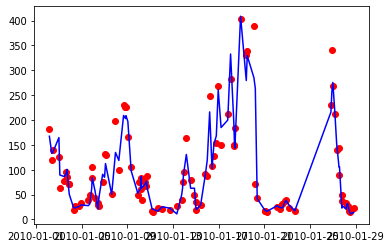

In [ ]:
plt.scatter(times[:100], result[:100,1], color = 'red')
plt.plot(times[:100], result[:100,0], color = 'blue')